In [1]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
require("pacman")
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

Loading required package: pacman



In [2]:
homeownership <- read_homeownership()

train <- head(homeownership, -4)
test <- tail(homeownership, 4)
arima_fit <- fit_arima(training_data = train$Value, p_range = 0:5, d_range = 0:2, q_range = 0:5)
head(arima_fit)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,4,1,4,84.58706
2,5,2,5,91.42805
3,5,2,1,92.86359
4,3,1,3,93.41243
5,5,1,2,93.63021
6,2,1,2,93.79914



	Box-Ljung test

data:  residuals(model)
X-squared = 1.7212, df = 1, p-value = 0.1895


	Box-Ljung test

data:  residuals(model)^2
X-squared = 3.4489, df = 1, p-value = 0.06329



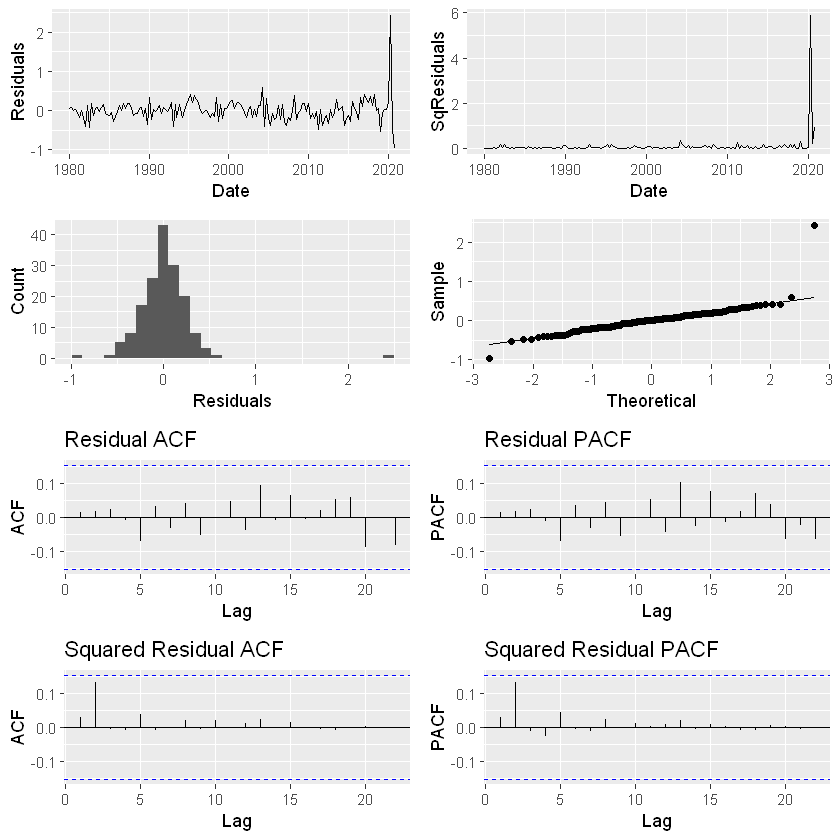

In [3]:
arima_model <- arima(train$Value, order = c(4,1,4), method = "ML")
residual_analysis(arima_model, train$Date)
box_tests(arima_model, 8)

In [4]:
seasonal_factors = list(order = c(1,0,1), period = 4)
sarima_fit <- fit_sarima(train$Value, 0:5, 0:2, 0:5, list(order = c(1,0,1), period = 4))
head(sarima_fit)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,2,1,5,91.86538
2,3,1,4,92.88787
3,4,1,3,93.54328
4,2,1,2,94.49545
5,5,1,0,94.76491
6,4,1,2,94.77973



	Box-Ljung test

data:  residuals(model)
X-squared = 0.85023, df = 1, p-value = 0.3565


	Box-Ljung test

data:  residuals(model)^2
X-squared = 11.784, df = 1, p-value = 0.0005974



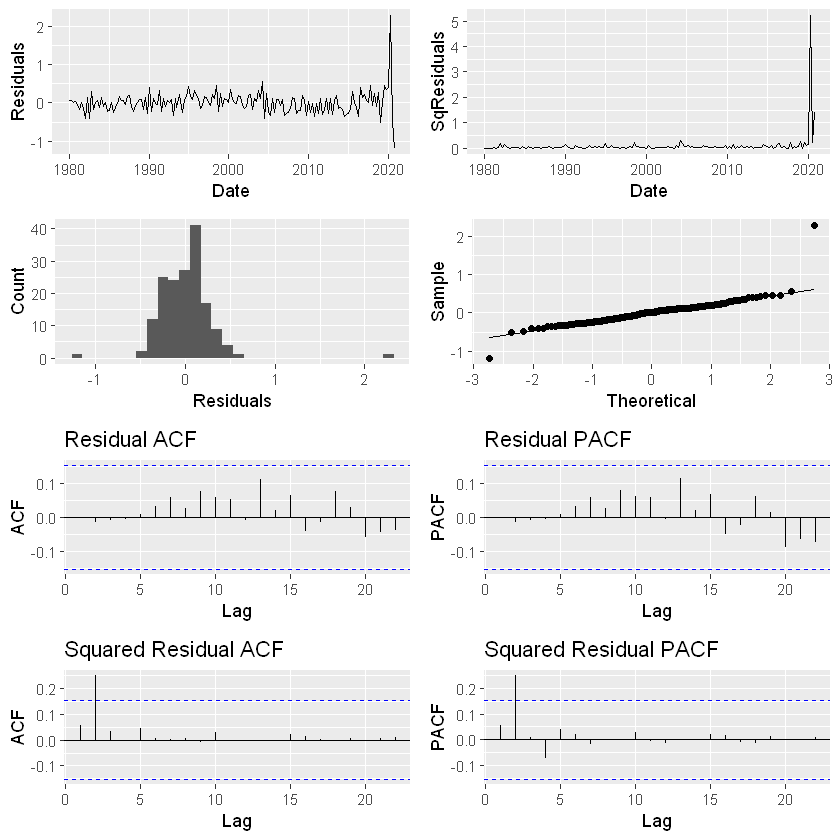

In [5]:
sarima_model <- arima(train$Value, order = c(2,1,5), seasonal = seasonal_factors, method = "ML")
residual_analysis(sarima_model, train$Date)
box_tests(sarima_model, 7)

In [6]:
outliers <- tsoutliers(homeownership$Value)
outliers
cleaned_homeownership <- homeownership
cleaned_homeownership$Value[outliers$index] <- outliers$replacements
cleaned_train <- head(cleaned_homeownership, -4)
cleaned_test <- tail(cleaned_homeownership, 4)

$index
[1] 162 163

$replacements
[1] 65.43333 65.56667

In [7]:
clean_arima_fit <- fit_arima(cleaned_train$Value, 0:5, 0:2, 0:5)
head(clean_arima_fit)
clean_sarima_fit <- fit_sarima(cleaned_train$Value, 0:5, 0:2, 0:5, seasonal_factors)
head(clean_sarima_fit)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,4,1,5,-76.35795
2,5,1,4,-76.35673
3,5,1,5,-75.04167
4,3,1,3,-73.91852
5,3,1,4,-71.71477
6,4,1,3,-71.71368


,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,4,1,5,-78.86194
2,5,1,5,-77.63816
3,3,1,3,-75.72996
4,2,0,2,-75.58924
5,5,0,0,-75.38850
6,1,1,2,-74.35416



	Box-Ljung test

data:  residuals(model)
X-squared = 3.3503, df = 1, p-value = 0.06719


	Box-Ljung test

data:  residuals(model)^2
X-squared = 8.0608, df = 1, p-value = 0.004523



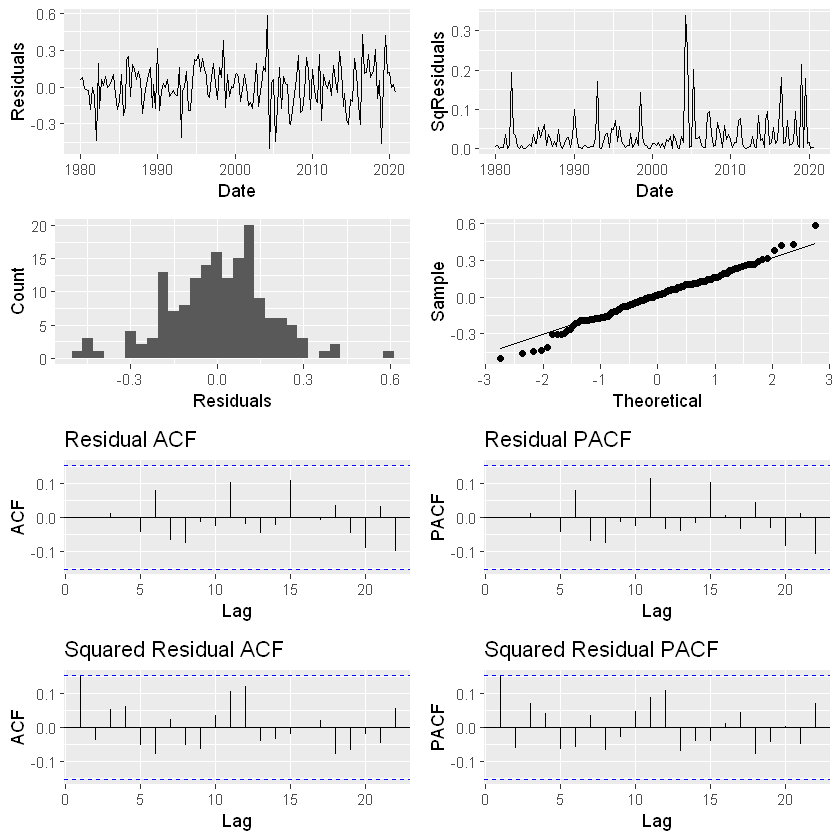

In [8]:
cleaned_arima_model <- arima(cleaned_train$Value, order = c(4,1,5), method = "ML", optim.control = list(maxit = 1000))
residual_analysis(cleaned_arima_model, cleaned_train$Date)
box_tests(cleaned_arima_model, 9)


	Box-Ljung test

data:  residuals(model)
X-squared = 5.6173, df = 1, p-value = 0.01778


	Box-Ljung test

data:  residuals(model)^2
X-squared = 7.3184, df = 1, p-value = 0.006825



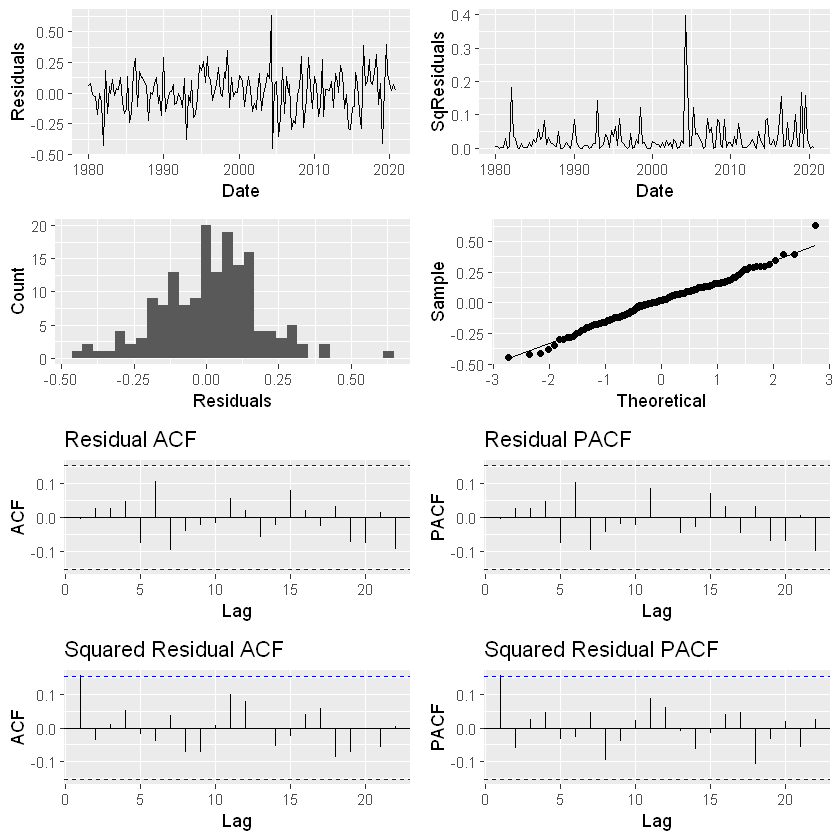

In [9]:
cleaned_sarima_model <- arima(cleaned_train$Value, order = c(4,1,5), seasonal = seasonal_factors, method = "ML", optim.control = list(maxit = 1000))
residual_analysis(cleaned_sarima_model, cleaned_train$Date)
box_tests(cleaned_sarima_model, 9)

PM =  231.539

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.474615,1.521641,1.474615,-2.251603,2.251603


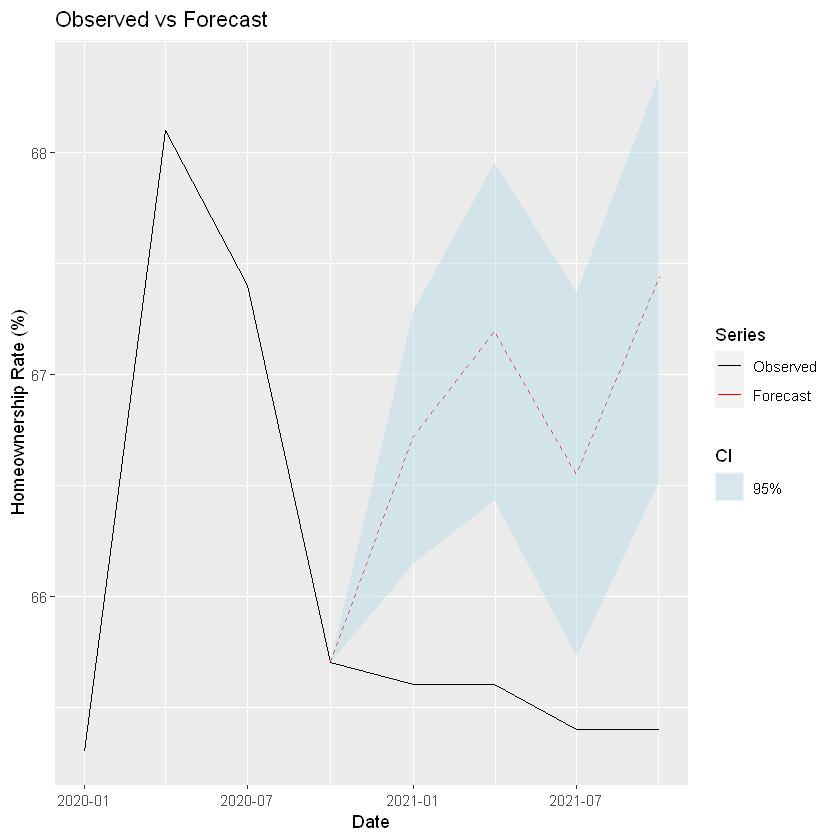

In [10]:
fc <- forecast_arima(arima_model, homeownership$Date, test$Value, 4, 95,
                    y_lab = "Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  151.6417

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.025901,1.231429,1.101266,-1.56544,1.680677


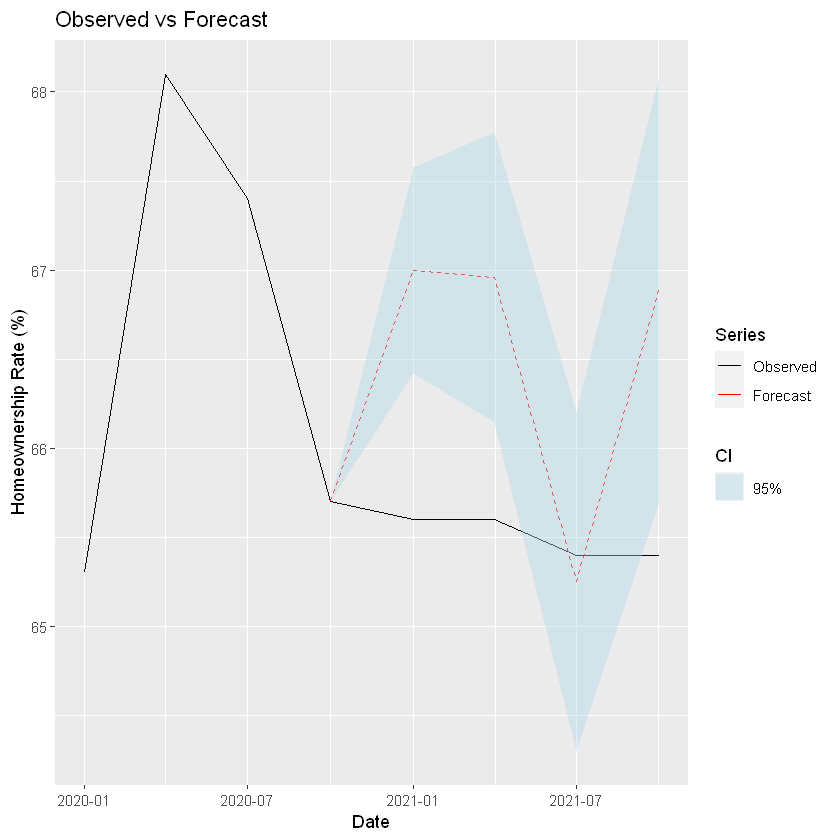

In [11]:
fc <- forecast_arima(sarima_model, homeownership$Date, test$Value, 4, 95,
                    y_lab = "Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  51.88867

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.6547899,0.7203379,0.6547899,-1.000345,1.000345


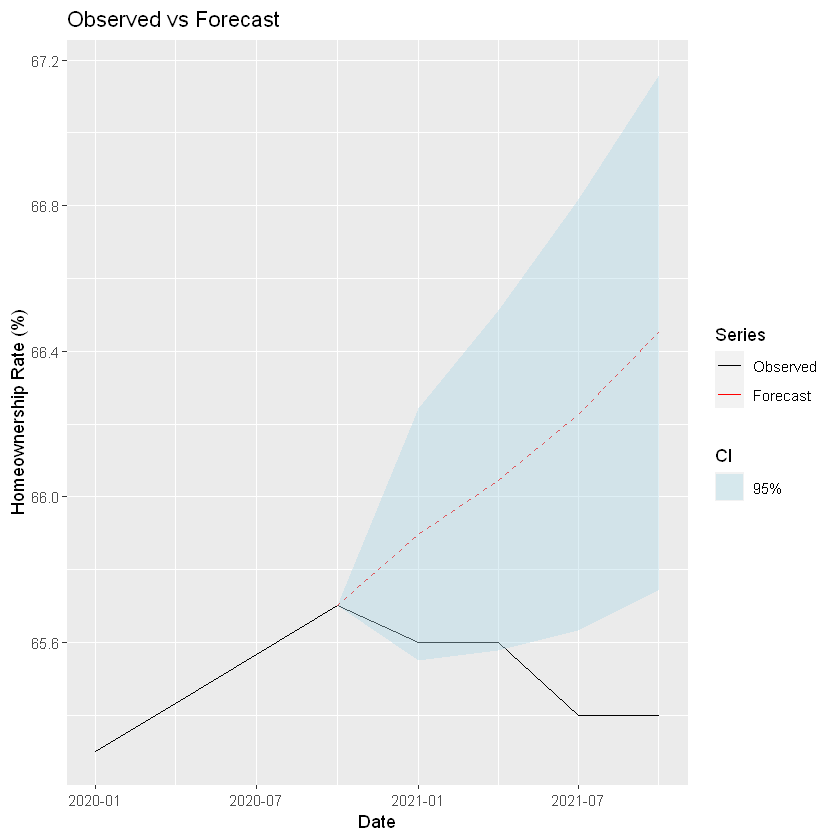

In [12]:
fc <- forecast_arima(cleaned_arima_model, homeownership$Date, test$Value, 4, 95,
                    y_lab = "Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  49.36765

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.6546574,0.7026212,0.6546574,-1.00004,1.00004


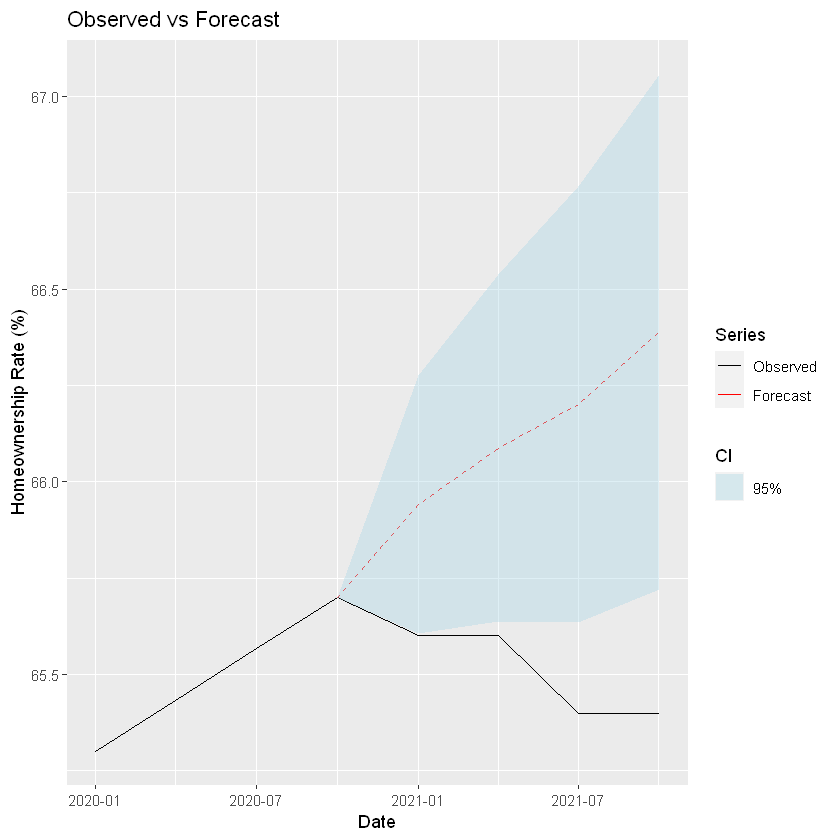

In [13]:
fc <- forecast_arima(cleaned_sarima_model, homeownership$Date, test$Value, 4, 95,
                    y_lab = "Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)